In [229]:
import wandb
import numpy as np
import torch
from torch.utils.data import DataLoader
import tensorflow as tf
import os

from scipy.linalg import sqrtm
from scipy.signal import welch
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

from diff_ts import EpsilonTheta
from diff_ts import GaussianDiffusion
from diff_ts_class import EpsilonThetaClass
from diff_ts_class import GaussianDiffusionClass
from datagenfordiff import SynthSignalsDataset
from tqdm.auto import tqdm


c:\Users\Alexia\anaconda3\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate Datasets


In [151]:
#Load Model For Testing WITH CLASS CONDITIONAL

model_save_path = 'C:/Users/Alexia/models_report/class_conditional.pth'
model =  GaussianDiffusionClass(EpsilonThetaClass(num_classes = 5,
        #cond_length,
        time_emb_dim=8,
        residual_layers=8,
        residual_channels=16,
        dilation_cycle_length=2,
        residual_hidden=16,
        class_emb_dim = 8,
        target_dim=1,), input_size=256)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_save_path}")

Model loaded from C:/Users/Alexia/models_report/class_conditional.pth


In [145]:
#Load Model For Testing WITH CLASSIFIER GUIDANCE

model_save_path = 'C:/Users/Alexia/models_report/classifier_guidance.pth'
model =  GaussianDiffusionClass(EpsilonThetaClass(num_classes = 5,
        #cond_length,
        time_emb_dim=16,
        residual_layers=12,
        residual_channels=64,
        dilation_cycle_length=2,
        residual_hidden=32,
        class_emb_dim = 16,
        target_dim=1,
        
    ), input_size=256)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_save_path}")

Model loaded from C:/Users/Alexia/models_report/classifier_guidance.pth


In [161]:
#LOAD MODEL WITHOUT CLASSES

model_save_path = 'C:/Users/Alexia/models_report/one_class.pth'
model =  GaussianDiffusion(EpsilonTheta(target_dim=1), input_size=256)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_save_path}")

Model loaded from C:/Users/Alexia/models_report/one_class.pth


In [ ]:
model.eval()

In [163]:
#Make Dataset 1000 sameples GENERATED SIGNALS NO CLASS

num_signals = 1000
batch_size = 10  
generated_signals = []

with torch.no_grad():
    while len(generated_signals) < num_signals:
        noise_shape = (batch_size, 1, 256)  
        random_noise = torch.randn(noise_shape, device=model.betas.device)
        batch_signals = model.p_sample_loop(random_noise)

        generated_signals.extend(batch_signals.squeeze().cpu().detach().numpy())


generated_signals = np.array(generated_signals)
if generated_signals.shape[0] > num_signals:
    generated_signals = generated_signals[:num_signals] 


assert generated_signals.shape == (1000, 256), "Dataset shape is incorrect."

In [147]:
#Make dataset 1000 GENERATED signals WITH CLASS

num_signals = 1000
generated_signals = []
generated_labels = []

n = 0
with torch.no_grad():
    while len(generated_signals) < num_signals:
        if n % 5 == 0:
            class_label = 4
        elif n % 5 == 1:
            class_label = 0
        elif n % 5 == 2:
            class_label = 1
        elif n % 5 == 3:
            class_label = 2
        elif n % 5 == 4:
            class_label = 3
        
        inputs = torch.randn((1, 1, 256))
        class_labels = torch.full((1,), fill_value=class_label, dtype=torch.long)
        batch_signals = model.p_sample_loop(inputs, class_labels)
        
        generated_signals.extend(batch_signals.squeeze().cpu().detach().numpy().reshape(-1, 256))
        generated_labels.extend([class_label] * batch_signals.size(0))

        n += 1

generated_signals = np.array(generated_signals)
generated_labels = np.array(generated_labels)

print("Generated signals shape:", generated_signals.shape)
print("Generated labels shape:", generated_labels.shape)
if generated_signals.shape[0] > num_signals:
    generated_signals = generated_signals[:num_signals]
    generated_labels = generated_labels[:num_signals]

assert generated_signals.shape == (1000, 256), "Dataset shape is incorrect."
assert generated_labels.shape == (1000,), "Labels shape is incorrect."


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [164]:
np.save('generated_signals_no_class_1000.npy', generated_signals)
np.save('generated_labels_no_class_1000.npy', generated_labels)

In [152]:
#Make Dataset 5000 Samples GENERATED SIGNALS WITH CLASSES 

num_signals_per_class = 1000
generated_signals = []
generated_labels = []

n = 0
with torch.no_grad():
    while len(generated_signals) < 5 * num_signals_per_class:
        if n % 5 == 0:
            class_label = 4
        elif n % 5 == 1:
            class_label = 0
        elif n % 5 == 2:
            class_label = 1
        elif n % 5 == 3:
            class_label = 2
        elif n % 5 == 4:
            class_label = 3
        
        inputs = torch.randn((1, 1, 256))
        class_labels = torch.full((1,), fill_value=class_label, dtype=torch.long)
        batch_signals = model.p_sample_loop(inputs, class_labels)
        
        generated_signals.extend(batch_signals.squeeze().cpu().detach().numpy().reshape(-1, 256))
        generated_labels.extend([class_label] * batch_signals.size(0))
        n += 1

generated_signals = np.array(generated_signals)
generated_labels = np.array(generated_labels)

print("Generated signals shape:", generated_signals.shape)
print("Generated labels shape:", generated_labels.shape)
if generated_signals.shape[0] > 5 * num_signals_per_class:
    generated_signals = generated_signals[:5 * num_signals_per_class]
    generated_labels = generated_labels[:5 * num_signals_per_class]

assert generated_signals.shape == (5000, 256), "Dataset shape is incorrect."
assert generated_labels.shape == (5000,), "Labels shape is incorrect."


Generated signals shape: (5000, 256)
Generated labels shape: (5000,)


In [153]:
np.save('generated_signals_class_conditional_5000.npy', generated_signals)
np.save('generated_labels_class_conditional_5000.npy', generated_labels)

In [219]:
#CHOOSE DATASET TO TEST ON

generated_signals = np.load('generated_signals_classifier_guidance_1000.npy')
generated_labels = np.load('generated_labels_classifier_guidance_1000.npy')

In [204]:
#CHOOSE DATASET TO TEST ON

generated_signals = np.load('generated_signals_class_conditional_1000.npy')
generated_labels = np.load('generated_labels_class_conditional_1000.npy')

In [206]:
#CHOOSE DATASET TO TEST ON

generated_signals = np.load('generated_signals_no_class_1000.npy')
generated_labels = np.load('generated_labels_no_class_1000.npy')

In [207]:
#LOAD training DATASET WITHOUT CLASSES

file_path = 'C:/Users/Alexia/datasets/train_set.pth'
dataset = torch.load(file_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=None)

original_signals = []

for i, data in enumerate(train_loader):
    signals = data['signals']  
    for signal in signals:
  
        flattened_signal = signal.squeeze().cpu().numpy()
        original_signals.append(flattened_signal)


real_signals = np.stack(original_signals)

sample_size = 1000
index = np.random.choice(real_signals.shape[0], sample_size, replace=False)  

real_data_samples = real_signals[:sample_size]
real_data_samples.shape


(1000, 256)

In [220]:
# LOAD TRAINING DATASET WITH CLASSES

import torch
from torch.utils.data import DataLoader
import numpy as np


file_path = 'C:/Users/Alexia/datasets/rand_0_no.pth'
dataset = torch.load(file_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=None)

original_signals = {0: [], 1: [], 2: [], 3: [], 4: []}


for i, data in enumerate(train_loader):
    signals = data['signals']
    classes = data['sc']
    for signal, cls in zip(signals, classes):
        flattened_signal = signal.squeeze().cpu().numpy()
        original_signals[cls.item()].append(flattened_signal)


num_samples_per_class = 200
real_data_samples = []
real_data_labels = []


for cls in range(5):
    class_signals = original_signals[cls]
    sampled_indices = np.random.choice(len(class_signals), num_samples_per_class, replace=False)
    sampled_class_signals = [class_signals[idx] for idx in sampled_indices]
    real_data_samples.extend(sampled_class_signals)
    real_data_labels.extend([cls] * num_samples_per_class)


real_data_samples = np.array(real_data_samples)
real_data_labels = np.array(real_data_labels)

assert real_data_samples.shape == (1000, 256), "Dataset shape is incorrect."
print("Final dataset shape (original):", real_data_samples.shape)
print("Labels shape (original):", real_data_labels.shape)


Final dataset shape (original): (1000, 256)
Labels shape (original): (1000,)


In [155]:
#LOAD DATASET 5000 SAMPLES FROM TRAINING 


file_path = 'C:/Users/Alexia/datasets/rand_0_no.pth'
dataset = torch.load(file_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=None)

original_signals = {0: [], 1: [], 2: [], 3: [], 4: []}


for i, data in enumerate(train_loader):
    signals = data['signals']
    classes = data['sc']
    for signal, cls in zip(signals, classes):
        flattened_signal = signal.squeeze().cpu().numpy()
        original_signals[cls.item()].append(flattened_signal)


num_samples_per_class = 1000
real_data_samples = []
real_data_labels = []

for cls in range(5):
    class_signals = original_signals[cls]
    sampled_indices = np.random.choice(len(class_signals), num_samples_per_class, replace=False)
    sampled_class_signals = [class_signals[idx] for idx in sampled_indices]
    real_data_samples.extend(sampled_class_signals)
    real_data_labels.extend([cls] * num_samples_per_class)


real_data_samples = np.array(real_data_samples)
real_data_labels = np.array(real_data_labels)


assert real_data_samples.shape == (5000, 256), "Dataset shape is incorrect."
print("Final dataset shape (original):", real_data_samples.shape)
print("Labels shape (original):", real_data_labels.shape)


Final dataset shape (original): (5000, 256)
Labels shape (original): (5000,)


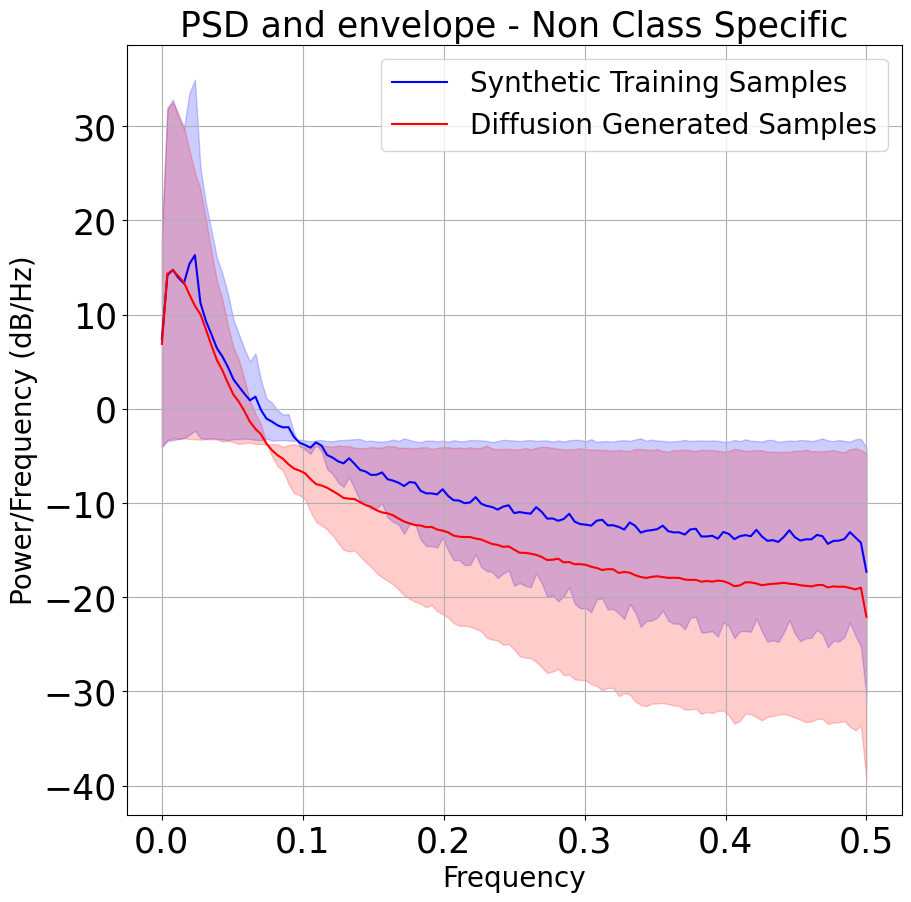

In [209]:
# Update plot parameters
plt.rcParams.update({'font.size': 30,       
                     'axes.titlesize': 25,    
                     'axes.labelsize': 20,     
                     'xtick.labelsize': 25,    
                     'ytick.labelsize': 25,  
                     'legend.fontsize': 20}) 

# Function to compute PSD, mean and standard deviation
def power_spectral_density(signals, fs=1.0):
    psds = []
    for signal in signals:
        freqs, psd = welch(signal, fs=fs, nperseg=len(signal))
        psds.append(psd)
    psds = np.array(psds)
    psd_mean = np.mean(psds, axis=0)
    psd_std = np.std(psds, axis=0)
    return freqs, psd_mean, psd_std

# Assuming you have the data for generated_signals and real_data_samples
# Example data (you should replace these with your actual data)
# generated_signals = np.random.randn(1000, 256)  # Example shape
# real_data_samples = np.random.randn(1000, 256)

# Compute PSDs
freqs_generated, psd_mean_generated, psd_std_generated = power_spectral_density(generated_signals)
freqs_real, psd_mean_real, psd_std_real = power_spectral_density(real_data_samples)

plt.figure(figsize=(10, 10))

# Plot mean PSD for original signals
plt.plot(freqs_real, 10 * np.log10(psd_mean_real), label='Synthetic Training Samples', color='blue')
plt.fill_between(freqs_real, 10 * np.log10(psd_mean_real) - 10 * np.log10(psd_mean_real + psd_std_real), 10 * np.log10(psd_mean_real) + 10 * np.log10(psd_mean_real + psd_std_real), color='blue', alpha=0.2)

# Plot mean PSD for generated signals
plt.plot(freqs_generated, 10 * np.log10(psd_mean_generated), label='Diffusion Generated Samples', color='red')
plt.fill_between(freqs_generated, 10 * np.log10(psd_mean_generated) - 10 * np.log10(psd_mean_generated + psd_std_generated), 10 * np.log10(psd_mean_generated) + 10 * np.log10(psd_mean_generated + psd_std_generated), color='red', alpha=0.2)

plt.title('PSD and envelope - Non Class Specific')
plt.xlabel('Frequency')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()






PCA and t-sne


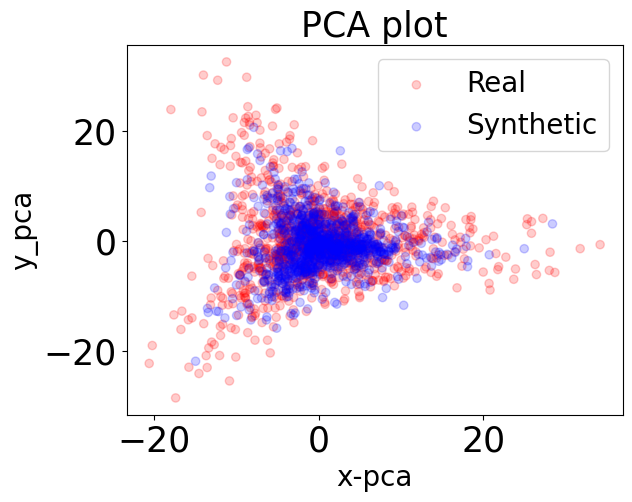

In [212]:
# PCA fitted on real data
# Parameters       
sample_size = 1000
colors = ["red" for i in range(sample_size)] +  ["blue" for i in range(sample_size)]

# PCA Analysis
pca = PCA(n_components = 2)
pca.fit(real_data_samples)
pca_results = pca.transform(real_data_samples)
pca_hat_results = pca.transform(generated_signals)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:sample_size], alpha = 0.2, label = "Real")
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[sample_size:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.show()

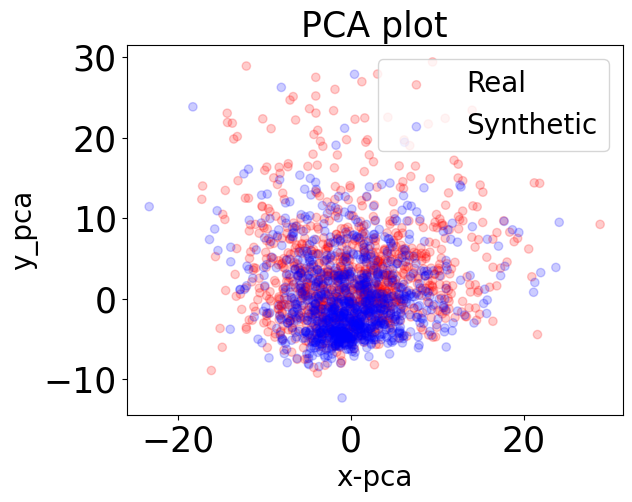

In [213]:
# PCA fitted on synthetic data
# Parameters        
colors = ["red" for i in range(sample_size)] +  ["blue" for i in range(sample_size)]

# PCA Analysis
pca = PCA(n_components = 2)
pca.fit(generated_signals)
pca_results = pca.transform(real_data_samples)
pca_hat_results = pca.transform(generated_signals)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:sample_size], alpha = 0.2, label = "Real")
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[sample_size:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.show()

In [214]:
# Do t-SNE Analysis together       
final_arrayX = np.concatenate((real_data_samples, generated_signals), axis = 0)
final_arrayX.shape

(2000, 256)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 5.688330
[t-SNE] KL divergence after 50 iterations with early exaggeration: 71.508514
[t-SNE] KL divergence after 300 iterations: 1.918694


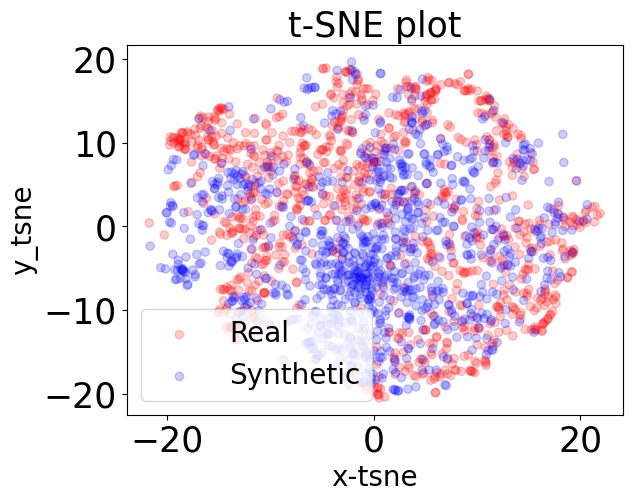

In [217]:
# TSNE anlaysis
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(final_arrayX)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(tsne_results[:sample_size,0], tsne_results[:sample_size,1], c = colors[:sample_size], alpha = 0.2, label = "Real")
plt.scatter(tsne_results[sample_size:,0], tsne_results[sample_size:,1], c = colors[sample_size:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.show()

real_data_samples shape: (1000, 256)
real_data_labels shape: (1000,)
generated_signals shape: (1000, 256)
generated_labels shape: (1000,)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 5.913939
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.719696
[t-SNE] KL divergence after 300 iterations: 1.316434


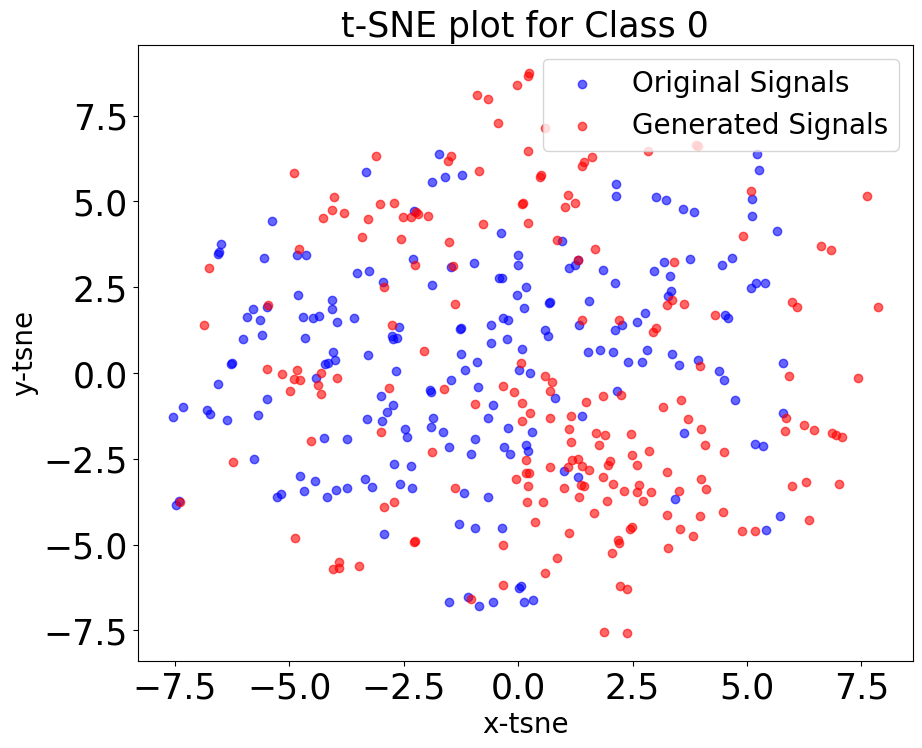

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 6.989463
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.162083
[t-SNE] KL divergence after 300 iterations: 1.227643


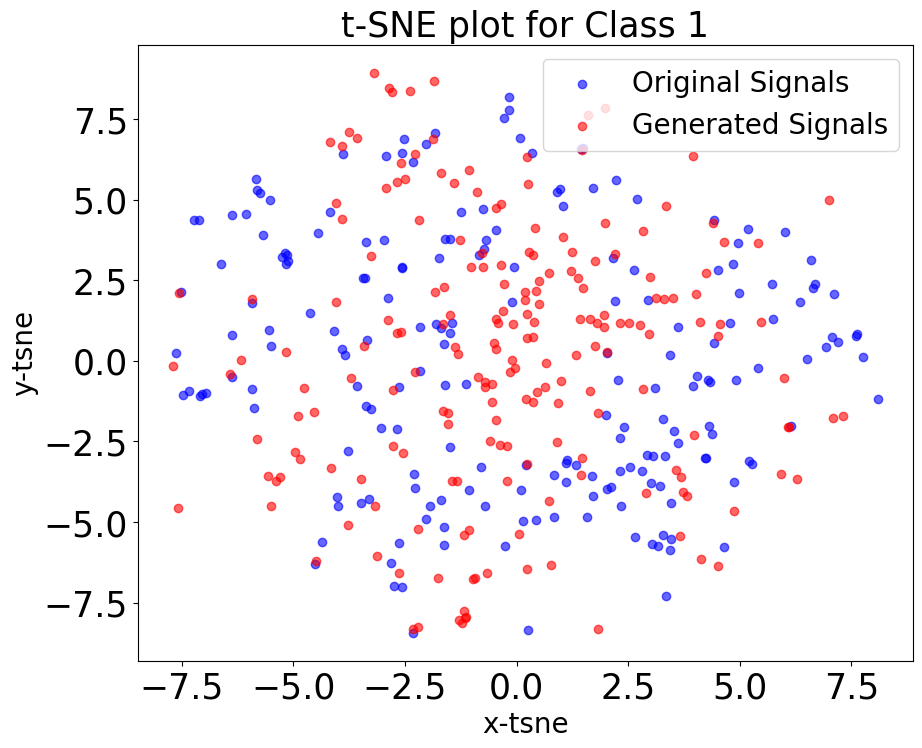

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 7.465530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.123699
[t-SNE] KL divergence after 300 iterations: 1.101909


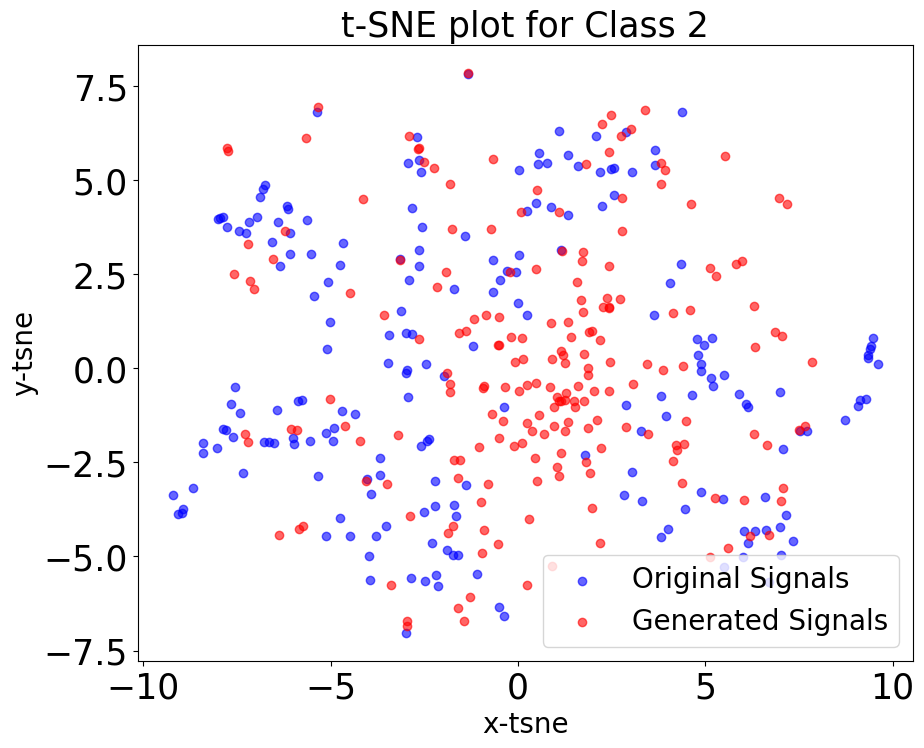

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 8.317882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.509216
[t-SNE] KL divergence after 300 iterations: 0.991537


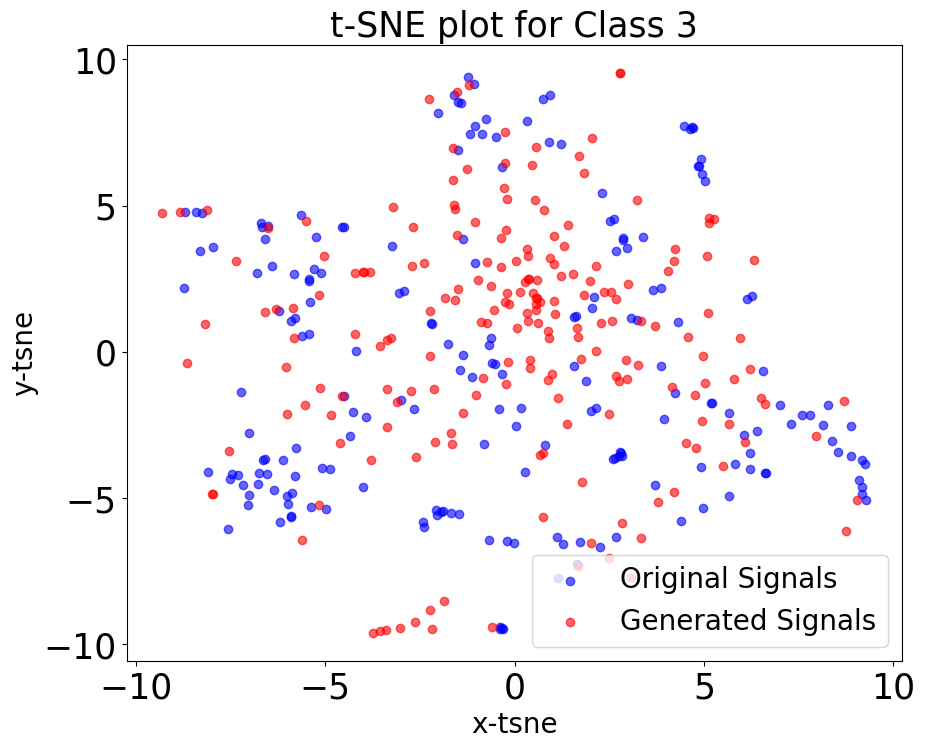

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 8.958912
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.342449
[t-SNE] KL divergence after 300 iterations: 1.032040


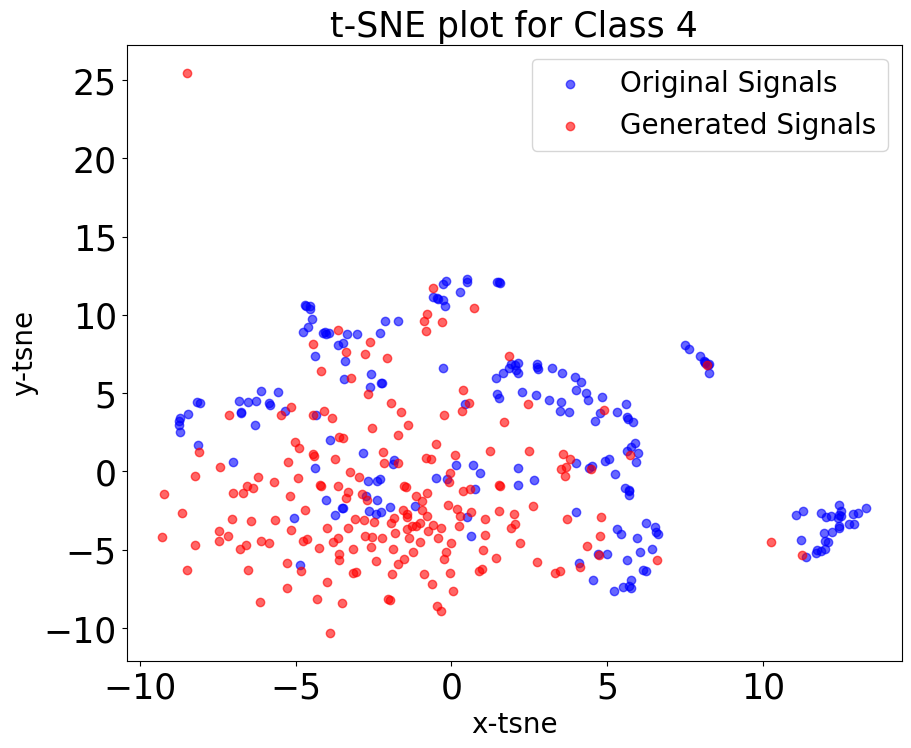

In [215]:
# Function to plot t-SNE for each class
def plot_tsne_for_class(class_label, real_signals, generated_signals_class):
    # Flatten the signals if they are not already flattened
    if real_signals.ndim > 2:
        real_signals = real_signals.reshape(real_signals.shape[0], -1)
    if generated_signals_class.ndim > 2:
        generated_signals_class = generated_signals_class.reshape(generated_signals_class.shape[0], -1)
    
    # Combine signals from both original and generated data
    combined_signals = np.concatenate((real_signals, generated_signals_class), axis=0)
    combined_labels = np.array([0] * len(real_signals) + [1] * len(generated_signals_class))
    
    # Generate t-SNE results
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(combined_signals)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[combined_labels == 0, 0], tsne_results[combined_labels == 0, 1], 
                color='blue', alpha=0.6, label='Original Signals')
    plt.scatter(tsne_results[combined_labels == 1, 0], tsne_results[combined_labels == 1, 1], 
                color='red', alpha=0.6, label='Generated Signals')
    plt.title(f't-SNE plot for Class {class_label}')
    plt.xlabel('x-tsne')
    plt.ylabel('y-tsne')
    plt.legend()
    plt.show()

# Assuming real_data_samples and real_data_labels are defined and loaded
real_data_samples = np.array(real_data_samples)
real_data_labels = np.array(real_data_labels)
generated_signals = np.array(generated_signals)
generated_labels = np.array(generated_labels)

# Verify the shapes
print("real_data_samples shape:", real_data_samples.shape)
print("real_data_labels shape:", real_data_labels.shape)
print("generated_signals shape:", generated_signals.shape)
print("generated_labels shape:", generated_labels.shape)

# Plot t-SNE for each class
for cls in range(5):
    real_signals = real_data_samples[real_data_labels == cls]
    generated_signals_class = generated_signals[generated_labels == cls]
    plot_tsne_for_class(cls, real_signals, generated_signals_class)

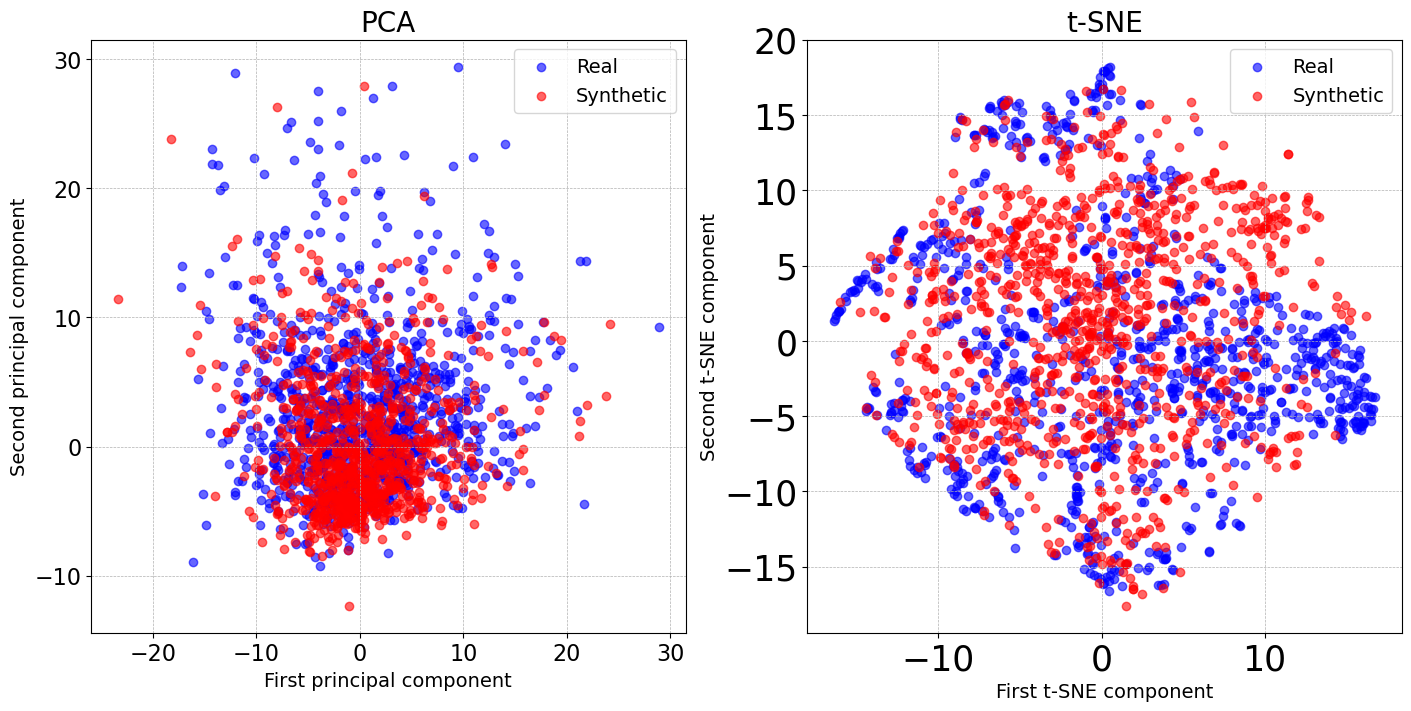

In [216]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec


# Plotting
fig = plt.figure(constrained_layout=True, figsize=(14, 7))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# PCA scatter plot
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title('PCA', fontsize=20)

ax1.scatter(pca_results[:, 0], pca_results[:, 1], c='blue', alpha=0.6, label='Real')
ax1.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], c='red', alpha=0.6, label='Synthetic')
ax1.legend(fontsize=14)
ax1.set_xlabel('First principal component', fontsize=14)
ax1.set_ylabel('Second principal component', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# t-SNE scatter plot
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('t-SNE', fontsize=20)

ax2.scatter(tsne_results[:sample_size, 0], tsne_results[:sample_size, 1], c='blue', alpha=0.6, label='Real')
ax2.scatter(tsne_results[sample_size:, 0], tsne_results[sample_size:, 1], c='red', alpha=0.6, label='Synthetic')
ax2.legend(fontsize=14)
ax2.set_xlabel('First t-SNE component', fontsize=14)
ax2.set_ylabel('Second t-SNE component', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()

INCEPTION SCORE

In [84]:
class ClassifierWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def predict_proba(self, signals):
        self.model.eval()
        with torch.no_grad():
            signals = torch.tensor(signals, dtype=torch.float32).to(self.device)
            signals = signals.unsqueeze(1)  # Add channel dimension if needed
            outputs = self.model(signals)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        return probabilities

In [85]:
# Calculate the Inception Score
def inception_score(predictions, eps=1e-16):
    """
    Compute the inception score for a set of predictions.
    
    Parameters:
    predictions (ndarray): Array of shape (N, num_classes) containing class probabilities for N samples.
    eps (float): Small value to avoid division by zero in log.
    
    Returns:
    float: Inception score.
    """

    p_y = np.mean(predictions, axis=0)

    kl_divergences = []
    for p_yx in predictions:
        kl_div = entropy(p_yx, p_y)
        kl_divergences.append(kl_div)

    is_score = np.exp(np.mean(kl_divergences))
    
    return is_score

In [227]:
#INCEPTION SCORE

device = 'cpu'

model_save_file = 'C:/Users/Alexia/classifiers/classif_90.pth'

model = get_model().to(device)
model.load_state_dict(torch.load(model_save_file))
classifier = ClassifierWrapper(model, device)

predictions = classifier.predict_proba(real_data_samples)

is_score = inception_score(predictions)
print(f"Inception Score: {is_score}")

Inception Score: 3.7467503547668457


CROSS CLASSIFICATION

              precision    recall  f1-score   support

     Class 0       0.94      0.90      0.92      1000
     Class 1       0.95      0.80      0.87      1000
     Class 2       0.81      0.89      0.85      1000
     Class 3       0.77      0.95      0.85      1000
     Class 4       0.97      0.85      0.91      1000

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000



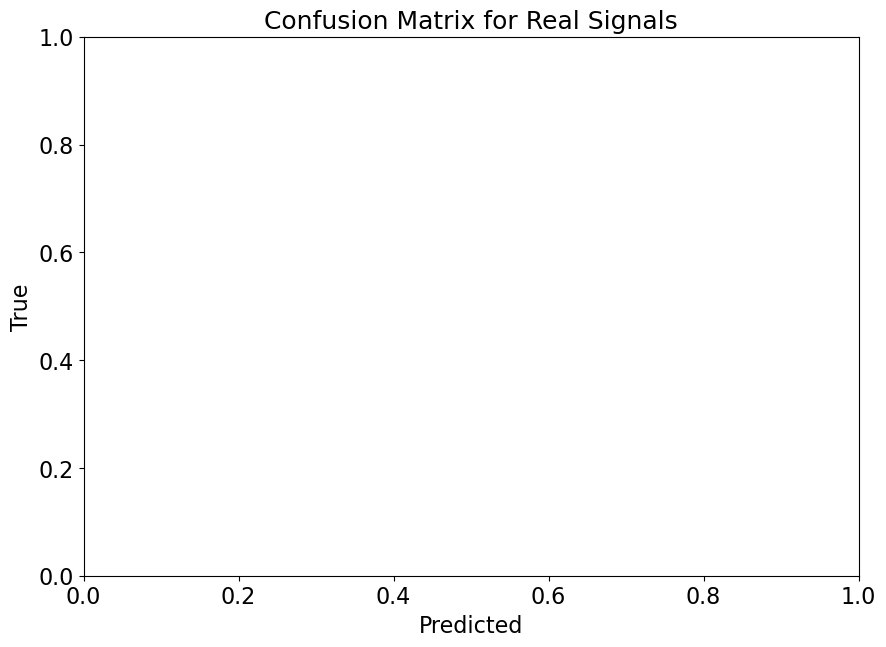

              precision    recall  f1-score   support

     Class 0       0.29      0.83      0.43      1000
     Class 1       0.12      0.13      0.12      1000
     Class 2       0.24      0.17      0.20      1000
     Class 3       0.32      0.10      0.15      1000
     Class 4       0.52      0.04      0.07      1000

    accuracy                           0.25      5000
   macro avg       0.30      0.25      0.19      5000
weighted avg       0.30      0.25      0.19      5000



<Figure size 640x480 with 0 Axes>

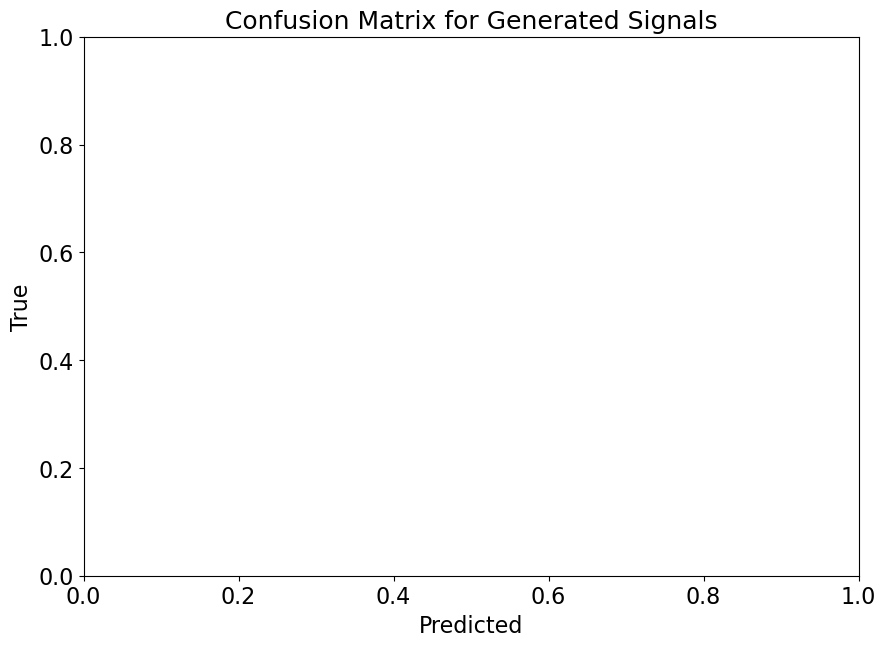

<Figure size 640x480 with 0 Axes>

In [93]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

def plot_cm(classifier, signals, labels, normalize=None, title='Confusion Matrix', save_path=None):
    # Predict the labels using the classifier
    y_pred = classifier.predict_proba(signals)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, y_pred, normalize=normalize)
    
    # Print the classification report
    print(classification_report(labels, y_pred, target_names=[f'Class {i}' for i in range(5)]))
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    #sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=[f'Class {i}' for i in range(5)], yticklabels=[f'Class {i}' for i in range(5)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
    
    # Save the confusion matrix plot if a save path is provided
    if save_path:
        plt.savefig(save_path)

# Example usage for real signals
plot_cm(classifier, real_data_samples, real_data_labels, normalize='true', title='Confusion Matrix for Real Signals', save_path='cm_real_signals.png')

# Example usage for generated signals
plot_cm(classifier, generated_signals, generated_labels, normalize='true', title='Confusion Matrix for Generated Signals', save_path='cm_generated_signals.png')


EUCLIDIAN DISTANCES

In [224]:
model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(generated_signals)
distances, indices = model.kneighbors(generated_signals)
distances, indices = distances[:,1], indices[:,1]
average_distance = np.mean(distances)
print(f"|D|synthetic = {round(average_distance,1)}")

|D|synthetic = 13.8


In [225]:
model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(real_data_samples)
distances, indices = model.kneighbors(real_data_samples)
distances, indices = distances[:,1], indices[:,1]
average_distance = np.mean(distances)
print(f"|D|real = {round(average_distance,1)}")

|D|real = 13.7


DISCRIMINATIVE SCORE

In [228]:
import torch.nn as nn

In [234]:
#Load Model For Testing WITH CLASS CONDITIONAL

model_save_path = 'C:/Users/Alexia/models_report/class_conditional.pth'
model2 =  GaussianDiffusionClass(EpsilonThetaClass(num_classes = 5,
        #cond_length,
        time_emb_dim=8,
        residual_layers=8,
        residual_channels=16,
        dilation_cycle_length=2,
        residual_hidden=16,
        class_emb_dim = 8,
        target_dim=1,), input_size=256)
model2.load_state_dict(torch.load(model_save_path))
model2.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_save_path}")

Model loaded from C:/Users/Alexia/models_report/class_conditional.pth


In [235]:
#Load Model For Testing WITH CLASSIFIER GUIDANCE

model_save_path = 'C:/Users/Alexia/models_report/classifier_guidance.pth'
model1 =  GaussianDiffusionClass(EpsilonThetaClass(num_classes = 5,
        #cond_length,
        time_emb_dim=16,
        residual_layers=12,
        residual_channels=64,
        dilation_cycle_length=2,
        residual_hidden=32,
        class_emb_dim = 16,
        target_dim=1,
        
    ), input_size=256)
model1.load_state_dict(torch.load(model_save_path))
model1.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_save_path}")

Model loaded from C:/Users/Alexia/models_report/classifier_guidance.pth


In [236]:
#LOAD MODEL WITHOUT CLASSES

model_save_path = 'C:/Users/Alexia/models_report/one_class.pth'
model3=  GaussianDiffusion(EpsilonTheta(target_dim=1), input_size=256)
model3.load_state_dict(torch.load(model_save_path))
model3.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_save_path}")

Model loaded from C:/Users/Alexia/models_report/one_class.pth


In [238]:
#CHOOSE DATASET TO TEST ON

generated_signals1 = np.load('generated_signals_classifier_guidance_5000.npy')
generated_labels1 = np.load('generated_labels_classifier_guidance_5000.npy')

In [239]:
#CHOOSE DATASET TO TEST ON

generated_signals2 = np.load('generated_signals_class_conditional_5000.npy')
generated_labels2 = np.load('generated_labels_class_conditional_5000.npy')

In [237]:
import torch
from torch.utils.data import Dataset

class GeneratedSignalsDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return {'signals': self.signals[idx], 'labels': self.labels[idx]}


In [233]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

def prepare_dataloaders(signals, labels, batch_size=32, test_size=0.3):
    dataset = GeneratedSignalsDataset(signals, labels)
    train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_ds = Subset(dataset, train_indices)
    val_ds = Subset(dataset, val_indices)
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    
    return train_dl, val_dl

# Example usage:

train_dl, val_dl = prepare_dataloaders(generated_signals1, generated_labels1)


  0%|          | 0/30 [00:00<?, ?it/s]

Model saved to discriminative_classifier.pth


  3%|▎         | 1/30 [00:35<16:58, 35.12s/it]

Model saved to discriminative_classifier.pth


  7%|▋         | 2/30 [01:14<17:28, 37.44s/it]

Model saved to discriminative_classifier.pth


 10%|█         | 3/30 [01:54<17:27, 38.78s/it]

Model saved to discriminative_classifier.pth


 13%|█▎        | 4/30 [02:33<16:49, 38.83s/it]

Model saved to discriminative_classifier.pth


 17%|█▋        | 5/30 [03:15<16:39, 39.98s/it]

Model saved to discriminative_classifier.pth


 20%|██        | 6/30 [03:57<16:14, 40.58s/it]

Model saved to discriminative_classifier.pth


 23%|██▎       | 7/30 [04:39<15:48, 41.23s/it]

Model saved to discriminative_classifier.pth


 27%|██▋       | 8/30 [05:19<14:58, 40.86s/it]

Model saved to discriminative_classifier.pth


 30%|███       | 9/30 [05:58<14:06, 40.31s/it]

Model saved to discriminative_classifier.pth


 33%|███▎      | 10/30 [06:38<13:22, 40.13s/it]

Model saved to discriminative_classifier.pth


 37%|███▋      | 11/30 [07:16<12:31, 39.53s/it]

Model saved to discriminative_classifier.pth


 40%|████      | 12/30 [07:54<11:40, 38.94s/it]

Model saved to discriminative_classifier.pth


 43%|████▎     | 13/30 [08:32<10:58, 38.76s/it]

Model saved to discriminative_classifier.pth


 47%|████▋     | 14/30 [09:16<10:42, 40.17s/it]

Model saved to discriminative_classifier.pth


 50%|█████     | 15/30 [09:55<10:00, 40.01s/it]

Model saved to discriminative_classifier.pth


 53%|█████▎    | 16/30 [10:36<09:23, 40.22s/it]

Model saved to discriminative_classifier.pth


 57%|█████▋    | 17/30 [11:17<08:44, 40.37s/it]

Model saved to discriminative_classifier.pth


 60%|██████    | 18/30 [11:57<08:02, 40.22s/it]

Model saved to discriminative_classifier.pth


 63%|██████▎   | 19/30 [12:31<07:04, 38.59s/it]

Model saved to discriminative_classifier.pth


 67%|██████▋   | 20/30 [13:01<05:58, 35.84s/it]

Model saved to discriminative_classifier.pth


 70%|███████   | 21/30 [13:32<05:08, 34.28s/it]

Model saved to discriminative_classifier.pth


 73%|███████▎  | 22/30 [14:03<04:26, 33.34s/it]

Model saved to discriminative_classifier.pth


 77%|███████▋  | 23/30 [14:34<03:48, 32.66s/it]

Model saved to discriminative_classifier.pth


 80%|████████  | 24/30 [15:05<03:12, 32.12s/it]

Model saved to discriminative_classifier.pth


 83%|████████▎ | 25/30 [15:35<02:38, 31.65s/it]

Model saved to discriminative_classifier.pth


 87%|████████▋ | 26/30 [16:06<02:05, 31.31s/it]

Model saved to discriminative_classifier.pth


 90%|█████████ | 27/30 [16:36<01:33, 31.14s/it]

Model saved to discriminative_classifier.pth


 93%|█████████▎| 28/30 [17:07<01:01, 30.95s/it]

Model saved to discriminative_classifier.pth


 97%|█████████▋| 29/30 [17:38<00:30, 30.87s/it]

Model saved to discriminative_classifier.pth


100%|██████████| 30/30 [18:09<00:00, 36.32s/it]

Finished Training


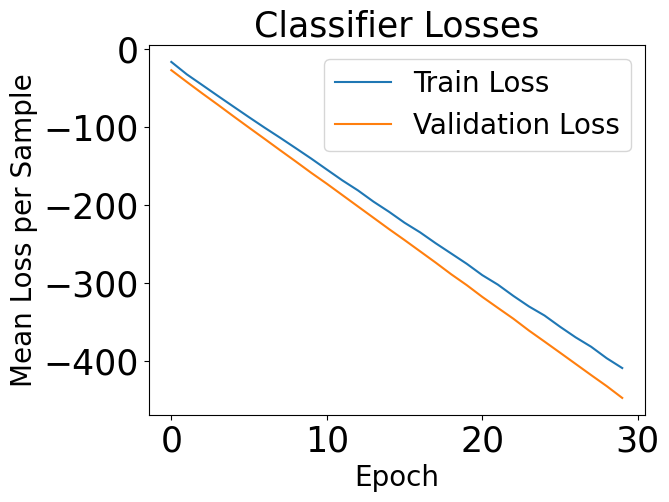

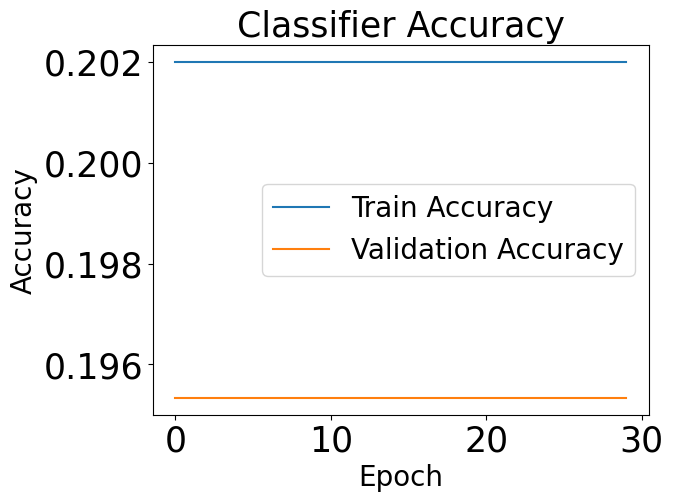

Accuracy on test data:  0.2


  0%|          | 0/30 [00:00<?, ?it/s]

Model saved to discriminative_classifier.pth


  3%|▎         | 1/30 [00:31<15:12, 31.48s/it]

Model saved to discriminative_classifier.pth


  7%|▋         | 2/30 [01:02<14:30, 31.08s/it]

Model saved to discriminative_classifier.pth


 10%|█         | 3/30 [01:33<13:55, 30.93s/it]

Model saved to discriminative_classifier.pth


 13%|█▎        | 4/30 [02:03<13:19, 30.76s/it]

Model saved to discriminative_classifier.pth


 17%|█▋        | 5/30 [02:33<12:45, 30.63s/it]

Model saved to discriminative_classifier.pth


 20%|██        | 6/30 [03:12<13:22, 33.46s/it]

Model saved to discriminative_classifier.pth


 23%|██▎       | 7/30 [03:53<13:43, 35.79s/it]

Model saved to discriminative_classifier.pth


 27%|██▋       | 8/30 [04:31<13:22, 36.46s/it]

Model saved to discriminative_classifier.pth


 30%|███       | 9/30 [05:09<12:54, 36.86s/it]

Model saved to discriminative_classifier.pth


 33%|███▎      | 10/30 [05:45<12:16, 36.81s/it]

Model saved to discriminative_classifier.pth


 37%|███▋      | 11/30 [06:25<11:54, 37.62s/it]

Model saved to discriminative_classifier.pth


 40%|████      | 12/30 [07:01<11:10, 37.25s/it]

Model saved to discriminative_classifier.pth


 43%|████▎     | 13/30 [07:37<10:27, 36.90s/it]

Model saved to discriminative_classifier.pth


 47%|████▋     | 14/30 [08:13<09:42, 36.42s/it]

Model saved to discriminative_classifier.pth


 50%|█████     | 15/30 [08:51<09:16, 37.12s/it]

Model saved to discriminative_classifier.pth


 53%|█████▎    | 16/30 [09:30<08:48, 37.72s/it]

Model saved to discriminative_classifier.pth


 57%|█████▋    | 17/30 [10:09<08:12, 37.90s/it]

Model saved to discriminative_classifier.pth


 60%|██████    | 18/30 [10:45<07:29, 37.49s/it]

Model saved to discriminative_classifier.pth


 63%|██████▎   | 19/30 [11:23<06:52, 37.47s/it]

Model saved to discriminative_classifier.pth


 67%|██████▋   | 20/30 [11:58<06:09, 36.93s/it]

Model saved to discriminative_classifier.pth


 70%|███████   | 21/30 [12:33<05:27, 36.35s/it]

Model saved to discriminative_classifier.pth


 73%|███████▎  | 22/30 [13:10<04:51, 36.45s/it]

Model saved to discriminative_classifier.pth


 77%|███████▋  | 23/30 [13:48<04:19, 37.03s/it]

Model saved to discriminative_classifier.pth


 80%|████████  | 24/30 [14:24<03:39, 36.59s/it]

Model saved to discriminative_classifier.pth


 83%|████████▎ | 25/30 [14:52<02:50, 34.16s/it]

Model saved to discriminative_classifier.pth


 87%|████████▋ | 26/30 [15:22<02:11, 32.78s/it]

Model saved to discriminative_classifier.pth


 90%|█████████ | 27/30 [15:52<01:36, 32.01s/it]

Model saved to discriminative_classifier.pth


 93%|█████████▎| 28/30 [16:28<01:06, 33.17s/it]

Model saved to discriminative_classifier.pth


 97%|█████████▋| 29/30 [17:04<00:34, 34.08s/it]

Model saved to discriminative_classifier.pth


100%|██████████| 30/30 [17:32<00:00, 35.10s/it]

Finished Training


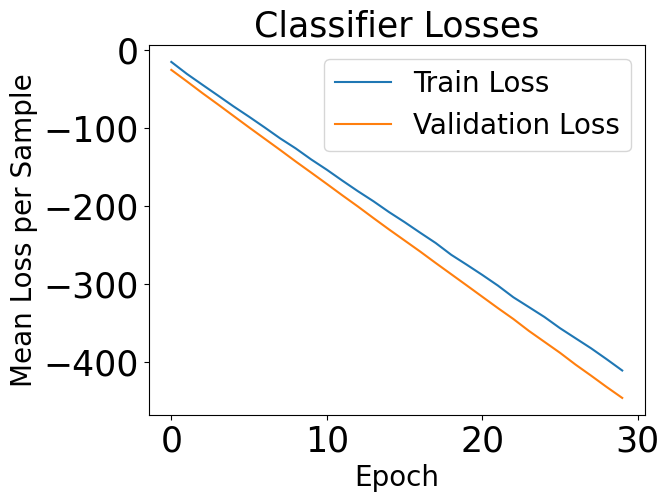

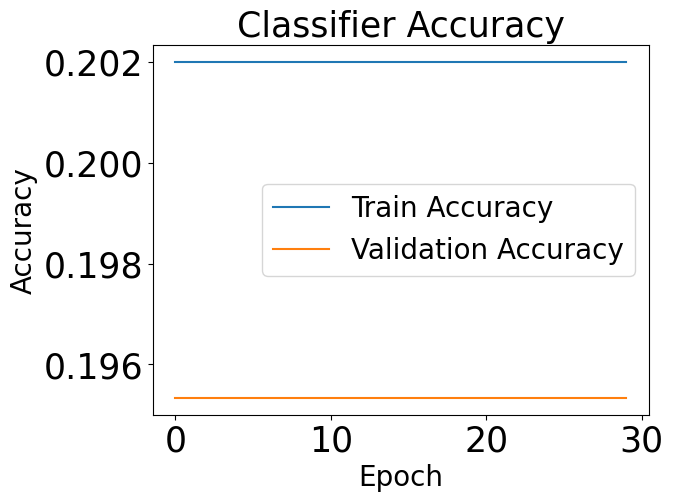

Accuracy on test data:  0.2


  0%|          | 0/30 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [245]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import pandas as pd
import plotly.graph_objects as go
from tqdm import tqdm

# Define your Classifier model
class Classifier(nn.Module):
    def __init__(self, nb_features, hidden_dim, num_layers=1, activation=False):
        super(Classifier, self).__init__()
        self.activation = activation
        self.rnn = nn.GRU(nb_features, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
        with torch.no_grad():
            for name, param in self.rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.fc.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
        
    def forward(self, data):
        data = data.permute(0, 2, 1)  # Ensure the shape is (batch_size, seq_length, num_features)
        output, hidden = self.rnn(data)
        if self.activation:
            return torch.mean(self.sigmoid(self.fc(output)), dim=1)
        return torch.mean(self.fc(output), dim=1)


# Accuracy function
def get_accuracy(dataloader, classifier):
    sigmoid = nn.Sigmoid()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            test_data, label = data['signals'], data['labels']
            outputs = classifier(test_data)
            predicted = torch.round(sigmoid(outputs)).squeeze()
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = correct / total
    return accuracy

# Function to create, train, and return a classifier
def create_train_classifier(train_dl, val_dl, device):
    epochs = 30
    hidden_dim = max(int(256 / 2), 1)  # Assuming max_sequence_length is 256
    criterion = nn.BCEWithLogitsLoss()
    classifier = Classifier(1, hidden_dim).to(device)
    opt = optim.Adam(classifier.parameters())
    
    min_valid_loss = np.inf
    mean_epoch_losses_train = []
    mean_epoch_losses_val = []
    accuracy_train = []
    accuracy_val = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        classifier.train()
        for i, data in enumerate(train_dl, 0):
            inputs, labels = data['signals'], data['labels']
            opt.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            opt.step()
            running_loss += loss.item()

        valid_loss = 0.0
        classifier.eval()
        for i, data in enumerate(val_dl, 0):
            inputs, labels = data['signals'], data['labels']
            outputs = classifier(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            valid_loss += loss.item()
        
        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            best_model_params = deepcopy(classifier.state_dict())
            model_path = f"discriminative_classifier.pth"
            torch.save(classifier.state_dict(), model_path)
            print(f"Model saved to {model_path}")
        
        mean_epoch_losses_train.append(running_loss / len(train_dl))
        mean_epoch_losses_val.append(valid_loss / len(val_dl))
        accuracy_train.append(get_accuracy(train_dl, classifier))
        accuracy_val.append(get_accuracy(val_dl, classifier))

    classifier.load_state_dict(best_model_params)
    print('Finished Training')

    plt.figure()
    plt.plot(mean_epoch_losses_train, label='Train Loss')
    plt.plot(mean_epoch_losses_val, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Loss per Sample')
    plt.title('Classifier Losses')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(accuracy_train, label='Train Accuracy')
    plt.plot(accuracy_val, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Classifier Accuracy')
    plt.legend()
    plt.show()
    
    return classifier

# Function to test the classifier
def test_classifier(classifier, test_dl):
    accuracy = get_accuracy(test_dl, classifier)
    return accuracy

# Function to calculate discriminative scores
def get_disc_score(train_dl, val_dl, test_dl, device):
    discriminative_scores = []
    for iteration in range(3):
        classifier = create_train_classifier(train_dl, val_dl, device)
        accuracy = test_classifier(classifier, test_dl)
        discriminative_score = round(accuracy, 2)
        print("Accuracy on test data: ", discriminative_score)
        discriminative_scores.append(discriminative_score)
    return discriminative_scores, np.mean(discriminative_scores)

# Assuming you have a function to generate synthetic signals
def generate_signals_from_diffusion_model(model, num_samples):
    # Generate synthetic signals using the diffusion model
    signals, masks, signalclasses = model.generate(num_samples)
    return signals, masks, signalclasses

# Use the device available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of diffusion models
diffusion_models = [
 
    model2,

]

# Loop through each diffusion model, generate signals, and calculate discriminative scores
for model in diffusion_models:
 
    
    train_dl, val_dl = prepare_dataloaders(generated_signals2, generated_labels2)

    

    
    # Calculate discriminative scores
    discriminative_scores, mean_discriminative_score = get_disc_score(train_dl, val_dl, val_dl, device)
    print(f"Discriminative Scores for {model.name}: ", discriminative_scores)
    print(f"Mean Discriminative Score for {model.name}: ", mean_discriminative_score)
